In [442]:
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score

### **Считываем данные**

1) df_ga_sessions - набор данных визитов на сайт (одна строка = один визит)

2) df_ga_hits - набор данных событий на сайте (одна строка = одно событие)

In [443]:
df_ga_sessions = pd.read_csv('ga_sessions.csv', low_memory=False)
df_ga_hits = pd.read_csv('ga_hits.csv', low_memory=False)

In [444]:
df_ga_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [445]:
df_ga_sessions.shape

(1860042, 18)

| Признак             |      Описание
|---------------------|------------------------------------------|
| **session_id**      |          ID визита |  
| **client_id**       |          ID клиента|      
| **visit_date**      |          Дата визита|          
| **visit_time**      |          Время визита|      
| **visit_number**    |          Порядковые номер визита клиента|       
| **utm_source**      |         Канал привлечения (закодирован)|       
| **utm_medium**      |          Тип привлечения|        
| **utm_campaign**    |          Рекламная компания (закодирован)|       
| **utm_adcontent**   |           |       
| **utm_keyword**     |          Ключевое слово (закодирован) |       
| **device_category** |          Тип устройства|      
| **device_os**       |          ОС устройства |        
| **device_brand**    |          Марка устройства |       
| **device_model**    |          Модель устройства|
| **device_screen_resolution**|   Разрешение экрана|
| **device_browser**         |   Используемый браузер|
| **geo_country**            |   Страна|
| **geo_city**               |   Город|

### Проверяем данные на пропуски

In [446]:
df_ga_sessions.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

Удалим признаки, в которых больше 50 %: пропусков:

1) utm_keyword
2) device_os
3) device_model

In [447]:
df_ga_sessions.drop(['utm_keyword', 'device_os', 'device_model'], axis=1, inplace=True)

### Заполнение пропусков - utm_source

In [448]:
df_ga_sessions[df_ga_sessions['utm_source'].isna()].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
77652,1100240274910044288.1640728207.1640728207,256169651.1637310592,2021-12-29,00:50:07,2,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,OnePlus,412x892,Chrome,Russia,Saint Petersburg
122841,1303431342277938317.1637250145.1637250145,303478758.1637239949,2021-11-18,18:42:25,3,NaN,Sbol_catalog,cccMlyVfjXspfaCSrMsO,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Balashikha
136220,1364914954463538089.1637595059.1637595059,317794027.1634397097,2021-11-22,18:30:59,8,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,YaBrowser,Russia,Moscow
136221,1364914954463538089.1638478637.1638478637,317794027.1634397097,2021-12-02,23:57:17,9,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,YaBrowser,Russia,Moscow
139706,1380043242326371104.1637518268.1637518268,321316356.1636477728,2021-11-21,21:11:08,4,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x740,Chrome,Russia,Izhevsk


In [449]:
# Заполняем utm_sourse (ищем такой же client_id и берем от туда utm_sourse )
client_to_utm = df_ga_sessions.dropna(subset=['utm_source']).groupby('client_id')['utm_source'].first().to_dict()
df_ga_sessions['utm_source'] = df_ga_sessions['utm_source'].fillna(df_ga_sessions['client_id'].map(client_to_utm))

In [450]:
df_ga_sessions.dropna(subset=['utm_source'], inplace=True)

In [451]:
df_ga_sessions.isna().sum()

session_id                       0
client_id                        0
visit_date                       0
visit_time                       0
visit_number                     0
utm_source                       0
utm_medium                       0
utm_campaign                219603
utm_adcontent               335615
device_category                  0
device_brand                367178
device_screen_resolution         0
device_browser                   0
geo_country                      0
geo_city                         0
dtype: int64

### В признаке utm_medium есть записи "(not set)" и (none), считаем их пропусками и заполняем

1. Строчки с (none) - явно с одним utm_medium - так как совпадает utm_campaign, utm_adcontent и utm_source

In [452]:
df_ga_sessions[df_ga_sessions['utm_medium'] == '(none)'].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
11,9055469620715506713.1628883994.1628883994,2108390820.1628883993,2021-08-13,22:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg
12,9055469620715506713.1633110583.1633110583,2108390820.1628883993,2021-10-01,20:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,1536x864,Chrome,Russia,Balashikha
29,9055507072827135870.1625692029.1625692029,2108399540.1625692030,2021-07-08,00:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x699,Chrome,Russia,Pushkino
30,9055507072827135870.1625694582.1625694582,2108399540.1625692030,2021-07-08,00:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x699,Chrome,Russia,Pushkino


In [453]:
df_ga_sessions[df_ga_sessions['utm_medium'] == '(none)'].shape

(300575, 15)

In [454]:
df_ga_sessions[(df_ga_sessions['utm_source'] ==  'fDLlAcSmythWSCVMvqvL') & 
               (df_ga_sessions['utm_adcontent'] ==  'JNHcPlZPxEMWDnRiyoBf') & 
               (df_ga_sessions['utm_campaign'] ==  'LTuZkdKfxRGVceoWkVyg')].shape

# 300575 значение с (none) + 5 значений с (not set)

(300580, 15)

Заполним utm_medium для этих записей одним значением

In [455]:
df_ga_sessions.loc[(df_ga_sessions['utm_source'] == 'fDLlAcSmythWSCVMvqvL') & 
                  (df_ga_sessions['utm_adcontent'] == 'JNHcPlZPxEMWDnRiyoBf') & 
                  (df_ga_sessions['utm_campaign'] == 'LTuZkdKfxRGVceoWkVyg'), 
                  'utm_medium'] = 'top_baner'

2. Строчки с (not set)

In [456]:
df_ga_sessions[df_ga_sessions['utm_medium'] == '(not set)'].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
14028,9117228372811440986.1636426594.1636426594,2122770150.1636426586,2021-11-09,05:56:34,1,iNFgfQPqHPBuvGCYtrQE,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,360x720,Chrome,Russia,Saint Petersburg
17049,9130968089155116617.1636081226.1636081226,2125969177.1636081225,2021-11-05,06:00:26,1,iNFgfQPqHPBuvGCYtrQE,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x896,Safari,Russia,(not set)
20218,9144903415488255785.1637263046.1637263046,2129213748.1634670377,2021-11-18,22:17:26,3,WeIwsqEbpZGZwhcQktNS,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,OnePlus,360x800,Chrome,Russia,Moscow
20219,9144903415488255785.1637295862.1637295862,2129213748.1634670377,2021-11-19,07:24:22,4,WeIwsqEbpZGZwhcQktNS,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,OnePlus,360x800,Chrome,Russia,Moscow
23827,9160652639657579968.1637324018.1637324018,2132880650.1636357568,2021-11-19,15:13:38,3,VCREhgqUPSUkmfOTvGiW,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,1920x1080,Edge,Russia,Moscow


Заполняем "not set" - по одинаковым utm_campaign, utm_adcontent и utm_source

In [457]:
df_ga_sessions.isna().sum()

session_id                       0
client_id                        0
visit_date                       0
visit_time                       0
visit_number                     0
utm_source                       0
utm_medium                       0
utm_campaign                219603
utm_adcontent               335615
device_category                  0
device_brand                367178
device_screen_resolution         0
device_browser                   0
geo_country                      0
geo_city                         0
dtype: int64

In [458]:
# Создаем копию датафрейма, чтобы не изменять исходный
df = df_ga_sessions.copy()

# Находим все строки с utm_medium = '(not set)'
not_set_mask = df['utm_medium'] == '(not set)'
not_set_rows = df[not_set_mask]
i = 2
# Для каждой такой строки находим соответствующую группу
for _, row in not_set_rows.iterrows():
    utm_source = row['utm_source']
    utm_campaign = row['utm_campaign']
    utm_adcontent = row['utm_adcontent']
    
    # Проверка на значения NaN в столбцах utm_source, utm_campaign и utm_adcontent
    if not (pd.isna(utm_source)) and not (pd.isna(utm_campaign)) and not (pd.isna(utm_adcontent)):
        group_mask = (  (df['utm_source'] == utm_source) &
                        (df['utm_campaign'] == utm_campaign) &
                        (df['utm_adcontent'] == utm_adcontent)
                     )
    elif not (pd.isna(utm_source)) and not (pd.isna(utm_campaign)) and (pd.isna(utm_adcontent)):
        group_mask = (  (df['utm_source'] == utm_source) &
                        (df['utm_campaign'] == utm_campaign)
                     )
    elif not (pd.isna(utm_source)) and (pd.isna(utm_campaign)) and not (pd.isna(utm_adcontent)):
        group_mask = (  (df['utm_campaign'] == utm_campaign) &
                        (df['utm_source'] == utm_source)
                     )
    elif (pd.isna(utm_source)) and not (pd.isna(utm_campaign)) and not (pd.isna(utm_adcontent)):
        group_mask = (  (df['utm_campaign'] == utm_campaign) &
                        (df['utm_adcontent'] == utm_adcontent)
                     )
    else:
        continue

    group_mediums = df.loc[group_mask, 'utm_medium']
    mode_medium = group_mediums.mode()[0] if not group_mediums.mode().empty else '(not set)'
    
    if mode_medium == '(not set)' or pd.isna(mode_medium):
        df.loc[group_mask, 'utm_medium'] = f'top_banner{i}'
        i =+1
    else:
        df.loc[group_mask, 'utm_medium'] = mode_medium


df_ga_sessions.loc[not_set_mask, 'utm_medium'] = df['utm_medium']

# Все что незаполнились удаляем
df_ga_sessions.drop(df_ga_sessions[df_ga_sessions['utm_medium'] == '(not set)'].index, inplace=True)

In [459]:
df_ga_sessions.isna().sum()

session_id                       0
client_id                        0
visit_date                       0
visit_time                       0
visit_number                     0
utm_source                       0
utm_medium                       0
utm_campaign                219603
utm_adcontent               335615
device_category                  0
device_brand                367178
device_screen_resolution         0
device_browser                   0
geo_country                      0
geo_city                         0
dtype: int64

### Обработка пропусков utm_campaign и  utm_utm_adcontent

In [460]:
# Удаляем столбцы - utm_campaign и  utm_utm_adcontent
df_ga_sessions.drop(['utm_campaign', 'utm_adcontent'], axis=1, inplace=True )

### Обработка пропусков device_brand

Заменим все значения (not set) и (none) на NaN

In [461]:
df_ga_sessions.replace(["(not set)", "(none)"], pd.NA, inplace=True)

In [462]:
# Удаляем столбец - device_brand
df_ga_sessions.drop(['device_brand'], axis=1, inplace=True )

### Обработка пропусков device_screen_resolution

In [463]:
df_ga_sessions[df_ga_sessions['device_screen_resolution'].isna()].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,device_category,device_screen_resolution,device_browser,geo_country,geo_city
130171,13368018095922515768.1632403702.1632403702,ee5faaa6-0674-488e-a95e-e19fb0886ace,2021-09-23,16:28:22,1,RmEBuqrriAfAVsLQQmhk,cpc,mobile,<NA>,Chrome,Russia,Ivanovo
210759,1698967678572805473.1632794208.1632794208,1448650c-c0f6-46bc-9fbb-f4c8fcd6d076,2021-09-28,04:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,mobile,<NA>,Chrome,Russia,Novosibirsk
229786,17841649634041484496.1632589524.1632589524,4cb93b4f-7d87-4843-a5dc-f489becf8dc5,2021-09-25,20:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,mobile,<NA>,Chrome,Russia,Orenburg
291016,2059368828467552826.1632662556.1632662556,ef366b80-ecec-4309-86c7-6b0fa9d87f47,2021-09-26,16:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,mobile,<NA>,Chrome,Russia,Saint Petersburg
354463,2341586666615441056.1637008506.1637008506,d90a77b7-a1e7-46b7-8d1d-29c452849d1d,2021-11-15,23:35:06,1,MvfHsxITijuriZxsqZqt,cpm,mobile,<NA>,Chrome,Russia,Moscow


In [464]:
mode_modile = df_ga_sessions[df_ga_sessions['device_category'] == 'mobile']['device_screen_resolution'].mode()[0]
mode_desktop = df_ga_sessions[df_ga_sessions['device_category'] == 'desktop']['device_screen_resolution'].mode()[0]
mode_tablet = df_ga_sessions[df_ga_sessions['device_category'] == 'tablet']['device_screen_resolution'].mode()[0]

# Создаем копию подмножества
subset = df_ga_sessions[df_ga_sessions['device_screen_resolution'].isna()].copy()

# Модифицируем копию
subset.loc[subset['device_category'] == 'mobile', 'device_screen_resolution'] = mode_modile
subset.loc[subset['device_category'] == 'desktop', 'device_screen_resolution'] = mode_desktop
subset.loc[subset['device_category'] == 'tablet', 'device_screen_resolution'] = mode_tablet

# Обновляем исходный DataFrame
df_ga_sessions.update(subset)

### Обработка пропусков признаков - device_browser, geo_country, geo_city

In [465]:
# Удаляем столбцы
df_ga_sessions = df_ga_sessions.dropna(subset=['device_browser', 'geo_country', 'geo_city'])

### Добавление целевой переменной

In [466]:
# Выбранные целевые действия
target_actions = [
    'potential_banner_click', 'request', 'rating_banner_show', 'click_car_buyback',
    'sber_id_auth_success', 'click_on_wallet', 'start_chat', 'go_to_offer',
    'go_to_car_card', 'showed_number_ads', 'phone_auth_start', 'click_on_get_code',
    'click_on_contact_us', 'click_setelem_credit', 'click_on_request_call',
    'click_sell', 'click_sell_car', 'click_buy_auto', 'click_pos_credit',
    'forward_to_price', 'tinkoff_credit_form_button', 'sravni_credit_form_button',
    'survey_buy_after_sell_start', 'mobile call', 'click_pos_credit', 'setelem_credit_form_button',
    'phone_auth_success', 'open_offer', 'show_popup_this_is_your_account', 'sub_car_claim_submit_click',
    'sub_car_request_submit_click', 'search_form_model_select', 'click_on_confirm_sms_code', 'code_sms_entered_success',
    'go_to_press_center', 'click_on_create_new_account', 'success_ad_creation', 'click_credit', 'name_entered_on_form_request_call',
    'click_auto_subscription', 'insurance_show', 'proactive invitation accepted', 'sap_search_form_cost_to', 'start_chat', 'sub_view_cars_click'
]

# Фильтрация df_ga_hits по целевым действиям
filtered_hits = df_ga_hits[df_ga_hits['event_action'].isin(target_actions)]

# Получение уникальных session_id с целевыми действиями
sessions_with_action = filtered_hits['session_id'].unique()

# Создание колонки action в df_ga_sessions
df_ga_sessions['action'] = 0 
df_ga_sessions.loc[df_ga_sessions['session_id'].isin(sessions_with_action), 'action'] = 1

df_ga_sessions['action'].value_counts()

# Удаляем ненужные признаки
df_ga_sessions.drop(['session_id', 'client_id'], axis=1, inplace=True)


In [467]:
df_ga_sessions.head()

,visit_date,visit_time,visit_number,utm_source,utm_medium,device_category,device_screen_resolution,device_browser,geo_country,geo_city,action
0,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,360x720,Chrome,Russia,Zlatoust,1
1,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,mobile,385x854,Samsung Internet,Russia,Moscow,0
2,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,360x720,Chrome,Russia,Krasnoyarsk,1
3,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,mobile,393x786,Chrome,Russia,Moscow,1
4,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,mobile,393x786,Chrome,Russia,Moscow,0


### Конвеер предварительной обработки данных
#### Классы предварительной обработки данных

In [468]:
class VisitDateTime(BaseEstimator, TransformerMixin):
    """Класс для преобразования данных visit_date и visit_time"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['visit_date'] = pd.to_datetime(X['visit_date'], format="%Y-%m-%d")
        X['visit_time'] = pd.to_datetime(X['visit_time'], format="%H:%M:%S")
        return X

In [469]:
class MonthDayHour(BaseEstimator, TransformerMixin):
    """Класс для создания новых признаков из данных visit_date и visit_time"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Создаем новые признаки (месяц, день недели, час)
        X['month'] = X['visit_date'].dt.month
        X['day_of_week'] = X['visit_date'].dt.dayofweek
        X['hour'] = (X['visit_time'].dt.hour + (X['visit_time'].dt.minute >= 30)) % 24
        return X

In [470]:
class TransformMonthDayHour(BaseEstimator, TransformerMixin):
    """Класс для преобразования признаков month, day_of_week, hour"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Преобразует дни недели
        X['sin_day_of_week'] = X['day_of_week'].apply(math.sin)
        X['cos_day_of_week'] = X['day_of_week'].apply(math.cos)

        #  Эти признаки помогают учитывать сезонность (летом значения будут отличаться от зимних)
        X['sin_month'] = X['month'].apply(math.sin)
        X['cos_month'] = X['month'].apply(math.cos)

        # Это помогает моделям учитывать повторяющиеся суточные паттерны (например, 0:00 и 23:00 — близкие по времени).
        X['sin_hour'] = X['hour'].apply(math.sin)
        X['cos_hour'] = X['hour'].apply(math.cos)
        X['sin**2_hour'] = X['sin_hour'] * X['sin_hour']
        X['cos**2_hour'] = X['cos_hour'] * X['cos_hour']
        return X

In [471]:
class NormalizedMonthDayHour(BaseEstimator, TransformerMixin):
    """Класс для нормализации признаков month, day_of_week, hour"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Преобразуем в диапазон [0, 2π] (нормализация)
        X['hour_sin'] = (X['hour'] / 23 * 2 * np.pi).apply(math.sin)
        X['hour_cos'] = (X['hour'] / 23 * 2 * np.pi).apply(math.cos)

        X['month_sin'] = ((X['month'] - 1) / 11 * 2 * np.pi).apply(math.sin)
        X['month_cos'] = ((X['month'] - 1) / 11 * 2 * np.pi).apply(math.cos)

        X['day_of_week_sin'] = ((X['day_of_week'] - 1) / 6 * 2 * np.pi).apply(math.sin)
        X['day_of_week_cos'] = ((X['day_of_week'] - 1) / 6 * 2 * np.pi).apply(math.cos)

        X['hour_sin**2'] = X['hour_sin'] * X['hour_sin']
        X['month_cos**2'] = X['month_cos'] * X['month_cos']
        X['day_of_week_cos**2'] = X['day_of_week_cos'] * X['day_of_week_cos']
        return X

In [472]:
class DropMonthDayHour(BaseEstimator, TransformerMixin):
    """Класс для удаления month, day_of_week, hour, visit_date, visit_time"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.drop(['month', 'hour', 'day_of_week', 'visit_date', 'visit_time'], axis=1, inplace=True)
        return X

In [473]:
class FeaturesEncoder(BaseEstimator, TransformerMixin):
    """Класс для кодирования переменных"""
    def fit(self, X, y=None):
        df = pd.concat([X, y], axis=1)
        self.dct = dict()
        for col in ['utm_source', 'utm_medium', 'device_category', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']:
            # Вычисляем среднее целевой переменной для каждой категории
            self.dct[col] = df.groupby(col)['action'].mean().to_dict()
        return self

    def transform(self, X):
        for col, d in self.dct.items():
            if col in X.columns:
                X[col] = X[col].map(d)
        return X

### Создание pipeline

In [474]:
# Разделим даннные на признаки и целевую переменную
# X содержит такие же признаки, которые будут отправлены с API
X_pipe = df_ga_sessions.drop(columns=['action'])
Y_pipe = df_ga_sessions['action']

X_pipe.head()

,visit_date,visit_time,visit_number,utm_source,utm_medium,device_category,device_screen_resolution,device_browser,geo_country,geo_city
0,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,360x720,Chrome,Russia,Zlatoust
1,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,mobile,385x854,Samsung Internet,Russia,Moscow
2,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,360x720,Chrome,Russia,Krasnoyarsk
3,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,mobile,393x786,Chrome,Russia,Moscow
4,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,mobile,393x786,Chrome,Russia,Moscow


In [475]:
dataPipe = Pipeline([
  ('Transform visit_date & visit_time', VisitDateTime()),
  ('Create features month, hour, day_of_week', MonthDayHour()),
  ('Math transform month, hour, day_of_week', TransformMonthDayHour()),
  ('Normalized month, hour, day_of_week', NormalizedMonthDayHour()),
  ('Drop month, day_of_week, hour, visit_date, visit_time', DropMonthDayHour()),
  ('Encoding features', FeaturesEncoder()),
  ])

encode_df = dataPipe.fit_transform(X_pipe, Y_pipe)
encode_df.head()

,visit_number,utm_source,utm_medium,device_category,device_screen_resolution,device_browser,geo_country,geo_city,sin_day_of_week,cos_day_of_week,...,cos**2_hour,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_sin**2,month_cos**2,day_of_week_cos**2
0,1,0.633141,0.630025,0.490959,0.392141,0.480228,0.503415,0.508929,0.909297,-0.416147,...,0.577126,-0.816970,-0.576680,-5.406408e-01,0.841254,0.866025,0.5,0.667440,0.707708,0.25
1,1,0.135088,0.128009,0.490959,0.468153,0.301931,0.503415,0.476765,-0.279415,0.960170,...,0.021170,0.816970,-0.576680,-5.406408e-01,0.841254,-0.866025,0.5,0.667440,0.707708,0.25
2,1,0.633141,0.630025,0.490959,0.392141,0.480228,0.503415,0.576838,0.841471,0.540302,...,0.980085,0.730836,0.682553,-2.449294e-16,1.000000,0.000000,1.0,0.534121,1.000000,1.00
3,1,0.486187,0.430047,0.490959,0.450750,0.480228,0.503415,0.476765,-0.958924,0.283662,...,0.080464,0.979084,0.203456,7.557496e-01,-0.654861,-0.866025,-0.5,0.958606,0.428843,0.25
4,2,0.486187,0.430047,0.490959,0.450750,0.480228,0.503415,0.476765,-0.958924,0.283662,...,0.080464,0.979084,0.203456,7.557496e-01,-0.654861,-0.866025,-0.5,0.958606,0.428843,0.25


### Оценка зависимости признаков и целевой переменной

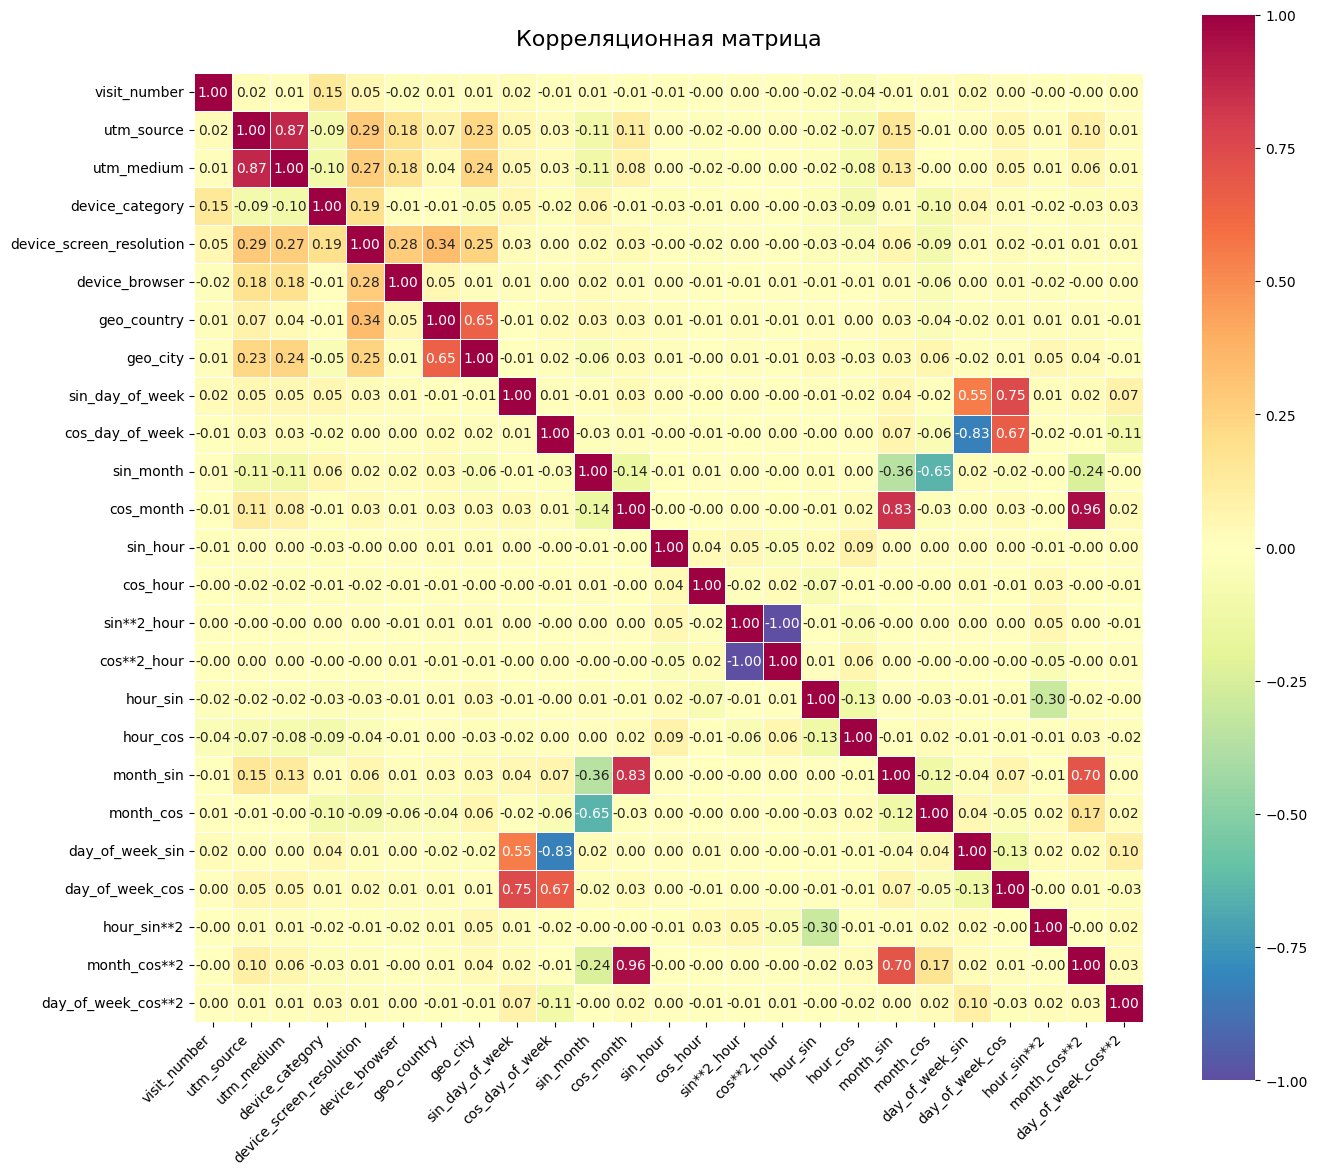

In [476]:
# Вычисляем корреляционную матрицу
C = encode_df.corr()
# Создаем тепловую карту
plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(C, 
                     annot=True,  # показывать значения в ячейках
                     fmt=".2f",   # формат чисел (2 знака после запятой)
                     cmap='Spectral_r',  
                     vmin=-1, vmax=1,  # диапазон значений корреляции
                     center=0,  # центр цветовой шкалы
                     square=True,  # квадратные ячейки
                     linewidths=0.5,  # толщина линий между ячейками
                     cbar_kws={"shrink": 0.8}  
                    )

# Настройки заголовка и шрифтов
plt.title('Корреляционная матрица', fontsize=16, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Убираем лишние пробелы
plt.tight_layout()

# Показать график
plt.show()

**Оценим зависимость признаков и целевой пререрменной с помощью Mutual Info**

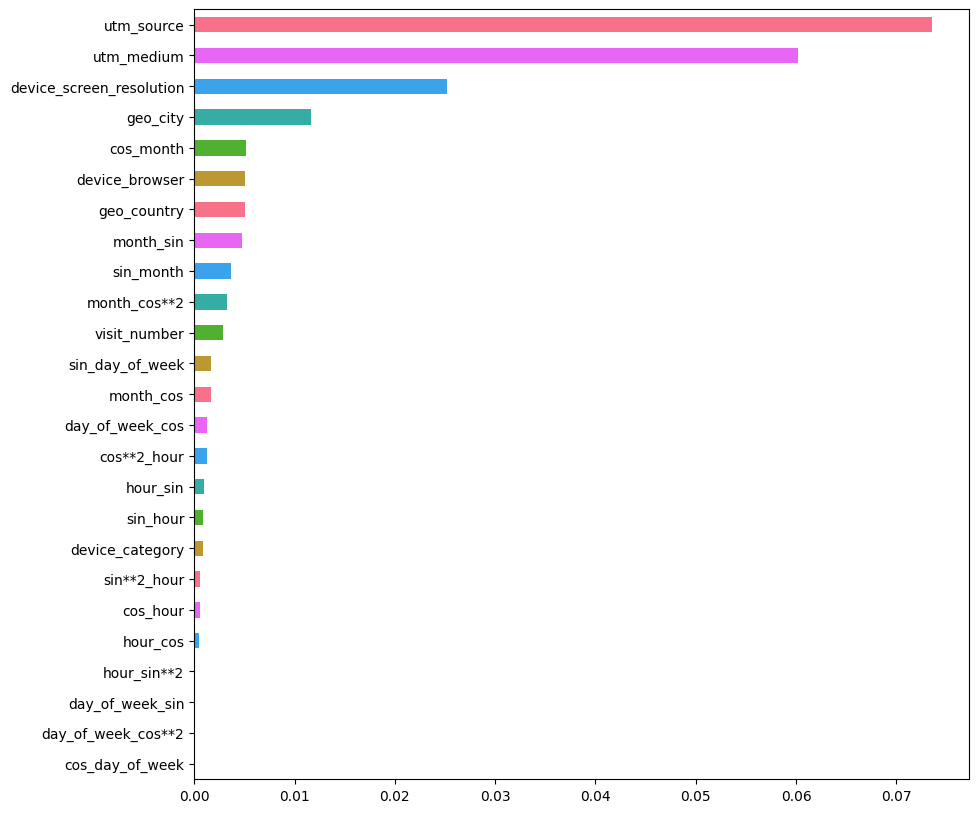

In [477]:
# Изучим зависимость признаков
importances = mutual_info_regression(X_pipe, Y_pipe)

feature_importances = pd.Series(importances, X_pipe.columns[0:len(X_pipe.columns)])
feature_importances = feature_importances.sort_values()

colors = sns.color_palette("husl")
plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh', color=colors)
plt.show()

Проверим на возможность сократить количество признаков с помощью PCA

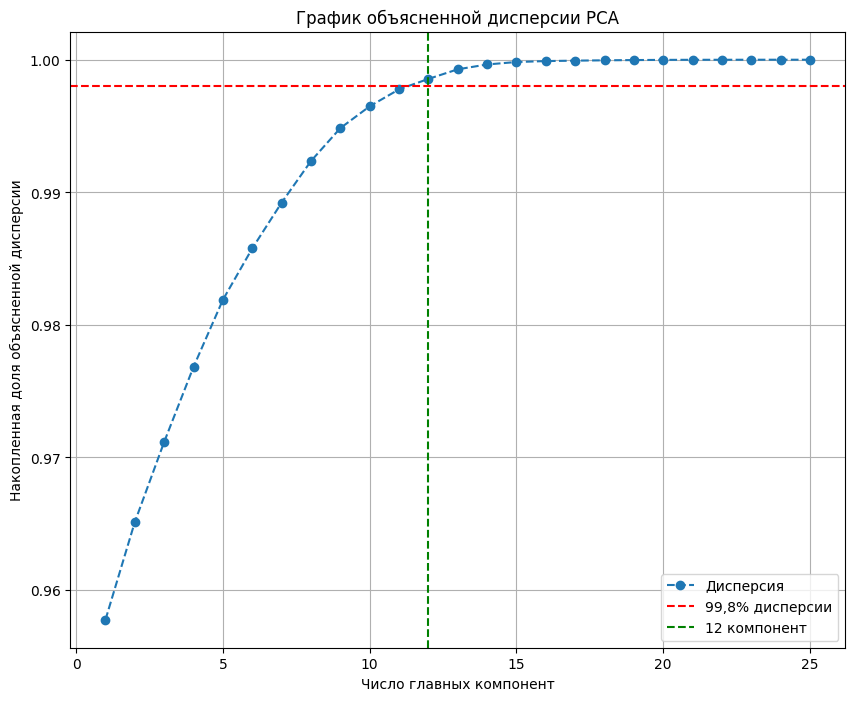

In [478]:
pca = PCA()
pca.fit(X_pipe)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label="Дисперсия")

# добавляем горизонтальную линию
plt.axhline(y=0.998, color='r', linestyle='--', label="99,8% дисперсии")

# добавляем вертикальную линию
plt.axvline(x=12, color='g', linestyle='--', label="12 компонент")

# рисуем график
plt.xlabel('Число главных компонент')
plt.ylabel('Накопленная доля объясненной дисперсии')
plt.title('График объясненной дисперсии PCA')
plt.legend()
plt.grid()
plt.show()

In [479]:
encode_df.drop(columns=feature_importances.index[0:8], inplace=True)

Разделим данные для обучения моделей

In [480]:
X = encode_df
Y = Y_pipe
X.head()

,visit_number,utm_source,utm_medium,device_screen_resolution,device_browser,geo_country,geo_city,sin_day_of_week,sin_month,cos_month,sin_hour,cos**2_hour,hour_sin,month_sin,month_cos,day_of_week_cos,month_cos**2
0,1,0.633141,0.630025,0.392141,0.480228,0.503415,0.508929,0.909297,-0.999990,0.004426,0.650288,0.577126,-0.816970,-5.406408e-01,0.841254,0.5,0.707708
1,1,0.135088,0.128009,0.468153,0.301931,0.503415,0.476765,-0.279415,-0.999990,0.004426,0.989358,0.021170,0.816970,-5.406408e-01,0.841254,0.5,0.707708
2,1,0.633141,0.630025,0.392141,0.480228,0.503415,0.576838,0.841471,-0.536573,0.843854,0.141120,0.980085,0.730836,-2.449294e-16,1.000000,1.0,1.000000
3,1,0.486187,0.430047,0.450750,0.480228,0.503415,0.476765,-0.958924,-0.958924,0.283662,-0.958924,0.080464,0.979084,7.557496e-01,-0.654861,-0.5,0.428843
4,2,0.486187,0.430047,0.450750,0.480228,0.503415,0.476765,-0.958924,-0.958924,0.283662,-0.958924,0.080464,0.979084,7.557496e-01,-0.654861,-0.5,0.428843



### Выбор модели и оценка метрик
#### Стандартизируем данные и разделим на выборки

In [481]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (1247292, 17), (1247292,)
Test dataset size: (534554, 17), (534554,)


#### Логистическая регрессия

In [482]:
model = LogisticRegression(
        max_iter=10000, 
        class_weight='balanced',  
        solver='lbfgs'  
    )

cv_auc_scores = cross_val_score(model, X_train, y_train, 
                              cv=5, 
                              scoring='roc_auc',
                              n_jobs=-1)  

print("ROC AUC на фолдах кросс-валидации:\n", cv_auc_scores)
print(f"Средний ROC AUC: {np.mean(cv_auc_scores):.3f} ± {np.std(cv_auc_scores):.3f}")

# Обучаем модель на всех тренировочных данных
model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_proba = model.predict_proba(X_test)[:, 1]  # Вероятности класса 1

# 5. Оценка качества
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC на тестcовых данных: {roc_auc:.3f}")


ROC AUC на фолдах кросс-валидации:
 [0.69450596 0.69415544 0.69627368 0.69533208 0.69447902]
Средний ROC AUC: 0.695 ± 0.001

ROC AUC на тестcовых данных: 0.693


#### Случайный лес

In [483]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Автоматическая балансировка
    random_state=42,
    n_jobs=-1
)

# Кросс-валидация
rf_cv_scores = cross_val_score(rf, X_train, y_train, 
                              cv=5, scoring='roc_auc', n_jobs=-1)
print("\nRandomForest ROC AUC на фолдах кросс-валидации:\n", rf_cv_scores)
print(f"Средний RF ROC AUC: {np.mean(rf_cv_scores):.3f}")

# Обучение и оценка на тесте
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:, 1]
print(f"RF Test ROC AUC: {(roc_auc_score(y_test, rf_proba)):.3f}")


RandomForest ROC AUC на фолдах кросс-валидации:
 [0.71535694 0.71467091 0.71469803 0.71586447 0.71467265]
Средний RF ROC AUC: 0.715
RF Test ROC AUC: 0.714


### CatBoost

Градиентный бустинг, был выбран алгоритм CatBoost, так как он лучше работает с  категориальными признаками.

In [484]:
catboost_model = CatBoostClassifier(
    iterations=1000,       
    learning_rate=0.05,    # скорость обучения
    depth=6,              # глубина деревьев
    eval_metric='AUC',    #  оптимизация
    random_state=42,
    verbose=0           
)

# Кросс-валидация
cb_cv_scores = cross_val_score(catboost_model, X_train, y_train, 
                              cv=5, scoring='roc_auc', n_jobs=-1)
print("\nCatBoost ROC AUC на фолдах кросс-валидации:\n", cb_cv_scores)
print(f"Средний CatBoost ROC AUC: {np.mean(cb_cv_scores):.3f} ")

# Обучение и оценка на тесте
catboost_model.fit(X_train, y_train)
cb_proba = catboost_model.predict_proba(X_test)[:, 1]
print(f"CatBoost Test ROC AUC: {(roc_auc_score(y_test, cb_proba)):.3f}")


CatBoost ROC AUC на фолдах кросс-валидации:
 [0.75819048 0.75783197 0.75828694 0.75871329 0.75783515]
Средний CatBoost ROC AUC: 0.758 
CatBoost Test ROC AUC: 0.758


### Конвеер обработки данных и его сериализация в pkl формат
#### Дополнительные классы для обработки данных

In [485]:
class DropFeatures(BaseEstimator, TransformerMixin):
    """ Класс для преобразования данных visit_date и visit_time"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lst = ['day_of_week_cos**2',
               'day_of_week_cos',
               'sin**2_hour',
               'hour_cos',
               'cos_day_of_week',
               'device_category',
               'day_of_week_sin',
               'sin_day_of_week']
        X.drop(columns=lst, inplace=True)
        return X

In [486]:
# Пересоздаем пайплайн используя обученный старый
# Стандартизация для выбранной модели не требуется, так как модель уже включает её в себя
new_pipeline = Pipeline([
  ('Transform visit_date & visit_time', VisitDateTime()),
  ('Create features month, hour, day_of_week', MonthDayHour()),
  ('Math transform month, hour, day_of_week', TransformMonthDayHour()),
  ('Normalized month, hour, day_of_week', NormalizedMonthDayHour()),
  ('Drop month, day_of_week, hour, visit_date, visit_time', DropMonthDayHour()),
  ('Encoding features', FeaturesEncoder()),
  ('Drop Features', DropFeatures()),
  ('Catboost Model', CatBoostClassifier(iterations=1000,
                                          learning_rate=0.05,
                                          depth=6,
                                          eval_metric='AUC',
                                          random_state=42,
                                          verbose=0))
])

X_pipe = df_ga_sessions.drop(columns=['action'])
Y_pipe = df_ga_sessions['action']

# Сериализируем и сохраняем в pkl файл
new_pipeline.fit(X_pipe, Y_pipe)

with open('model.pkl', 'wb') as output:
    pickle.dump(new_pipeline, output)

In [487]:
X_pipe = df_ga_sessions.drop(columns=['action'])
Y_pipe = df_ga_sessions['action']

In [488]:
# Проверим работоспособность преобразования данных
# Предсказания будут не корректными, так как модель обучалась на этих же данных
with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

df = model.predict(X_pipe)
print(df)

[1 0 1 ... 1 1 0]


## Общий вывод по проделанной работе

Работа была проведена для анализа сайта "СберАвтоподписка" на основе данных предоставленных в рамках проектного практикума.

Для решения задачи были использованы различные подходы по заполнению пропусков в данных:
- Были выявлены значения признаков (not set) и (none), которые при первичном анализе не были выявлены как NaN значения
- Были заполнены пропуски в признаках utm_sourse и utm_medium на основе данных о клиентах.
- Данные в признаке device_category были заполнены модальными значениями основывая за показателях устройств.
- Признаки содержащие пропуски более чем в 50% данных были удалены.

В качестве целевой переменной были определены категории even_action, относящиеся к целевой переменной и выбраны наиболее полезные для анализа пользователей.

Для обработки данных был собран конвеер - pipeline. Он включает в себя:
- Преобразование признаков содержащих дату и время и трансформирует их данных к переодическим значениям с помощью математических преобразований.
- Кодирование категориальных признаков, вычисляя среднее значение целевой переменной для каждой категории

Для оценки зависимость признаков и целевой пререрменной использовался:
- Корреляционная матрица
- Алгоритм Mutual Info
- Метод главных компанент (PCA)

Выбор модели и оценка метрик происходила с помощью кросс-валидации и тестировалась на моделях:
- Логистической регрессии
- Случайного леса
- CatBoost'а

Согласно заданию значение метрики ROC-AUC 0.65 было достингнуто и превышено на всех выбранных моделях. Однако наилучшие результаты показала модель CatBoost со значением метрики ROC-AUC в 0.76. Эта модель была включена в новый конвеер обработки данных и сериализована для дальнейшей работы.